# GSMM mixture modelling with real data

This notebook contains the following processing blocks:
- Gaussian mixture model
- Complex hierarchical gaussian filter
- Complex to real conversion
- Probabilistic Fourier transform
- Observation noise

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
using Random
using Printf
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 19                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 10                      # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer

duration_train = 3
duration_test = 5                          # time of testing data
stepsize_train = Int(bufsize/4)
stepsize_test = bufsize
nr_samples_train = Int((fs*duration_train-bufsize)/stepsize_train) +1
nr_samples_test = Int((fs*duration_test-bufsize)/stepsize_test) +1

Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:(1+maximum([duration_train, duration_test]))*fs_speech-1]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)[1:fs*duration_train] 
y_speech_true = preprocess(x_speech, fs_speech)[1:fs*duration_test] 
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsize_train, rectangularwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize_test, rectangularwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:maximum([length(y_speech), length(y_speech_true)])-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

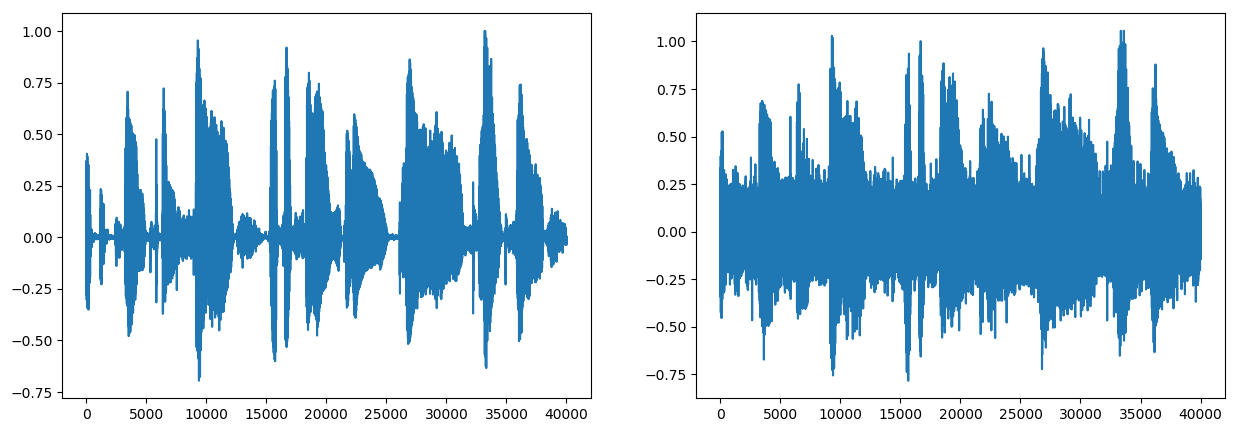

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000613C37B8>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

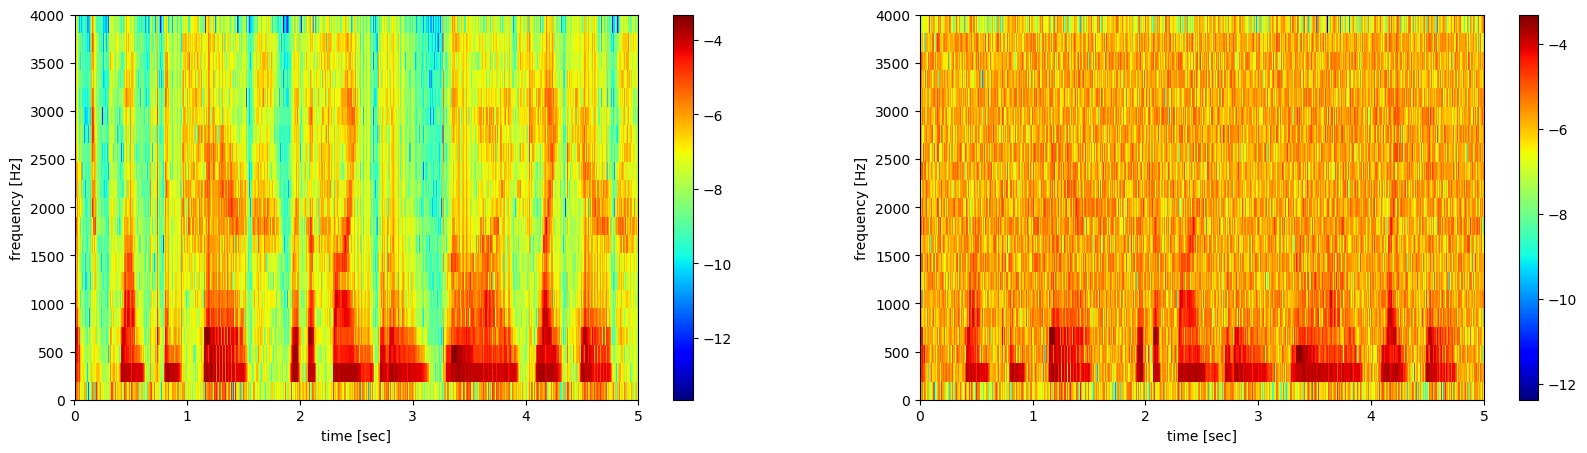

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[2], colorbar=true)
;

## Train GSMM through K-means and EM

In [7]:
# perform clustering (ignore DC and fs/2)
g = GMM(nr_clusters, z_speech[:,2:end-1], nIter=50, nInit=100, kind=:diag)
em!(g, z_speech[:,2:end-1])
;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.379185e+05
 

┌ Info: Initializing GMM, 10 Gaussians diag covariance 19 dimensions using 2397 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


     1       9.454354e+04      -4.337499e+04 |       10
      2       9.103140e+04      -3.512135e+03 |       10
      3       8.840065e+04      -2.630750e+03 |       10
      4       8.648521e+04      -1.915442e+03 |       10
      5       8.503103e+04      -1.454181e+03 |       10
      6       8.436387e+04      -6.671533e+02 |       10
      7       8.403678e+04      -3.270970e+02 |       10
      8       8.374021e+04      -2.965675e+02 |       10
      9       8.345080e+04      -2.894068e+02 |       10
     10       8.329572e+04      -1.550810e+02 |        9
     11       8.322093e+04      -7.478994e+01 |       10
     12       8.316542e+04      -5.550841e+01 |        8
     13       8.312338e+04      -4.204629e+01 |        7
     14       8.311791e+04      -5.470912e+00 |        6
     15       8.311385e+04      -4.053270e+00 |        5
     16       8.310484e+04      -9.014020e+00 |        3
     17       8.309732e+04      -7.520380e+00 |        4
     18       8.306439e+04      

┌ Info: K-means with 2397 data points using 38 iterations
│ 12.0 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


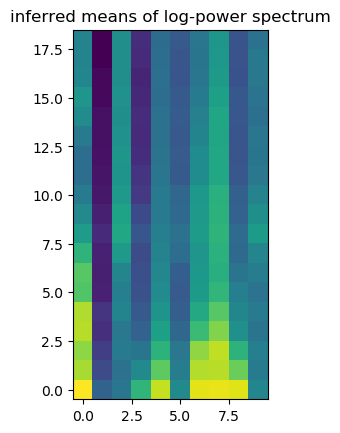

In [8]:
plt.imshow(g.μ', origin="lower")
plt.title("inferred means of log-power spectrum");

## Train GSMM through variational message passing on a factor graph

### Step 1: Build factor graph

In [9]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars = Dict()

# create mixture components
for k = 1:nr_clusters
    
    # specify distribution over precision matrix
    @RV vars[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars[pad(:w,k)])
    
end

@RV vars[:π] ~ Dirichlet(placeholder(:α_π, dims=(nr_clusters,)))

# specify distribution over selection variable
@RV vars[:z] ~ Categorical(vars[:π])

# create gaussian mixture model
@RV vars[:ξ] ~ GaussianMixture(vars[:z], expand([[vars[pad(:m,ki)], vars[pad(:w,ki)]] for ki=1:nr_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars[:Xc] ~ ComplexHGF(vars[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars[:Xr] ~ ComplexToReal(vars[:Xc])

# probabilistic Fourier transform
@RV vars[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars[:Xr]

# observation model 
@RV vars[:y] ~ GaussianMeanVariance(vars[:x], Σ_meas)

# observation
placeholder(vars[:y], :y, dims=(bufsize,))

# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3104827543523034475 -->
 3104827543523034475 
 
 = 
 equ_vars_w_01_1 
 
<!-- 8422176231895705229 -->
 8422176231895705229 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3104827543523034475--8422176231895705229 -->
 3104827543523034475--8422176231895705229 
 
 vars_w_01 
 3 w 
 2 2 
 
<!-- 11492160266412177810 -->
 11492160266412177810 
 
 GM 
 gaussianmixture_1 
 
<!-- 3104827543523034475--11492160266412177810 -->
 3104827543523034475--11492160266412177810 
 
 vars_w_01 
 4 w1 
 3 3 
 
<!-- 1425936087575219648 -->
 1425936087575219648 
 
 W 
 wishart_1 
 
<!-- 3104827543523034475--1425936087575219648 -->
 3104827543523034475--1425936087575219648 
 
 vars_w_01 
 1 out 
 1 1 
 
<!-- 17117591127266567481 -->
 17117591127266567481 
 
 placeholder_V_w_05 
 
<!-- 11614008858243353866 -->
 11614008858243353866 
 
 placeholder_V_w_08 
 
<!-- 11537401128573965988 -->
 11537401128573965988 
 
 placeholder_nu_w_07 
 
<!-- 3665578727352072453 -->
 3665578727352072453 
 
 = 
 equ_vars_w_02_1 
 
<!-- 3665578727352072453--11492160266412177810 -->
 3665578727352072453--11492160266412177810 
 
 vars_w_02 
 6 w2 
 3 3 
 
<!-- 3367630038662319103 -->
 3367630038662319103 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 3665578727352072453--3367630038662319103 -->
 3665578727352072453--3367630038662319103 
 
 vars_w_02 
 3 w 
 2 2 
 
<!-- 13314906873585895389 -->
 13314906873585895389 
 
 W 
 wishart_2 
 
<!-- 3665578727352072453--13314906873585895389 -->
 3665578727352072453--13314906873585895389 
 
 vars_w_02 
 1 out 
 1 1 
 
<!-- 7548126916900528988 -->
 7548126916900528988 
 
 W 
 wishart_9 
 
<!-- 18244528196211528839 -->
 18244528196211528839 
 
 placeholder_V_w_09 
 
<!-- 7548126916900528988--18244528196211528839 -->
 7548126916900528988--18244528196211528839 
 
 V_w_09 
 1 out 
 2 v 
 
<!-- 8231773216882864756 -->
 8231773216882864756 
 
 placeholder_nu_w_09 
 
<!-- 7548126916900528988--8231773216882864756 -->
 7548126916900528988--8231773216882864756 
 
 nu_w_09 
 1 out 
 3 nu 
 
<!-- 16862155139206985350 -->
 16862155139206985350 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 16815964810260175882 -->
 16815964810260175882 
 
 placeholder_μ_m_03 
 
<!-- 16862155139206985350--16815964810260175882 -->
 16862155139206985350--16815964810260175882 
 
 μ_m_03 
 1 out 
 2 m 
 
<!-- 15675729077181785483 -->
 15675729077181785483 
 
 placeholder_μ_m_01 
 
<!-- 8422176231895705229--15675729077181785483 -->
 8422176231895705229--15675729077181785483 
 
 μ_m_01 
 1 out 
 2 m 
 
<!-- 15614748274733425760 -->
 15614748274733425760 
 
 placeholder_V_w_10 
 
<!-- 8978171043612773662 -->
 8978171043612773662 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 15865047285878059069 -->
 15865047285878059069 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 8978171043612773662--15865047285878059069 -->
 8978171043612773662--15865047285878059069 
 
 vars_Xc 
 1 X 
 2 cx 
 
<!-- 17900304017726410649 -->
 17900304017726410649 
 
 placeholder_μ_m_09 
 
<!-- 1784367550586887067 -->
 1784367550586887067 
 
 W 
 wishart_4 
 
<!-- 1545510138317232385 -->
 1545510138317232385 
 
 placeholder_V_w_04 
 
<!-- 1784367550586887067--1545510138317232385 -->
 1784367550586887067--1545510138317232385 
 
 V_w_04 
 1 out 
 2 v 
 
<!-- 15930865454943279629 -->
 15930865454943279629 
 
 placeholder_nu_w_04 
 
<!-- 1784367550586887067--15930865454943279629 -->
 1784367550586887067--15930865454943279629 
 
 nu_w_04 
 1 out 
 3 nu 
 
<!-- 13700799873458141800 -->
 13700799873458141800 
 
 𝒩 
 gaussianmeanprecision_9 
 
<!-- 137007998734581

### Step 2: Generate inference algorithm

In [10]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
             expand([[pad(:M,k), pad(:W,k)] for k=1:nr_clusters]),
             :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars[:π],
                           expand([[vars[pad(:m,k)], vars[pad(:w,k)]] for k=1:nr_clusters])...,
                           vars[:z], vars[:Xc], vars[:ξ],
                           ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: create data and marginals dictionary

In [11]:
shuff = randperm(nr_samples_train)
y_samples_train = [y_speech[(k-1)*stepsize_train+1:(k-1)*stepsize_train+bufsize] for k = 1:nr_samples_train];
y_samples_test_true = [y_speech_true[(k-1)*stepsize_test+1:(k-1)*stepsize_test+bufsize] for k = 1:nr_samples_test];
y_samples_test_noisy = [y_speech_n[(k-1)*stepsize_test+1:(k-1)*stepsize_test+bufsize] for k = 1:nr_samples_test];
t_samples_train = [t[(k-1)*stepsize_train+1:(k-1)*stepsize_train+bufsize] for k = 1:nr_samples_train];
t_samples_test = [t[(k-1)*stepsize_test+1:(k-1)*stepsize_test+bufsize] for k = 1:nr_samples_test];
y_samples_train = y_samples_train[shuff]
t_samples_train = t_samples_train[shuff]

;

### Step 4: Perform inference

In [12]:
# calculate hyperparameter α based on cluster assignments of EM training
ll = llpg(g, z_speech[:,2:end-1])
llmin = maximum(ll, dims=2)
llnorm = ll .- llmin
znorm = exp.(llnorm) ./ sum(exp.(llnorm), dims=2)
α_π_min = squeeze(sum(znorm, dims=1))

10-element Array{Float64,1}:
 141.16855630718217
 293.18557337353275
 320.32687346259513
 206.7795398413353 
 118.7097949139065 
 184.37990790923845
 393.6526932555435 
 263.3344499210279 
 249.2749085060893 
 226.18770250954893

In [13]:
p_z_min = exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))) ./ sum(exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))))

10-element Array{Float64,1}:
 0.05880800036050505 
 0.12236014845712531 
 0.13370683143983358 
 0.08623727936645359 
 0.049418917310785446
 0.07687290273130783 
 0.16436140301687185 
 0.10988059881541717 
 0.10400287268786719 
 0.09435104581383298 

In [14]:
g.w

10-element Array{Float64,1}:
 0.05789399091426053 
 0.1232119357645736  
 0.13644809307476075 
 0.08538029224403698 
 0.048825353031725076
 0.07587235155869256 
 0.16821086670430158 
 0.10862855913549704 
 0.10356656272080252 
 0.09196199485134941 

In [15]:
# set number of iterations
nr_its = 10

# placeholders for priors
μ_m_min = Array{Array{Float64,1},1}(undef, nr_clusters)
nu_w_min = Array{Float64,1}(undef, nr_clusters)
V_w_min = Array{Array{Float64,2},1}(undef, nr_clusters)

# set priors (and current values later on)
α_π_min = α_π_min
p_z_min = exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))) ./ sum(exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))))
for k = 1:nr_clusters
    μ_m_min[k] = g.μ[k,:]
    nu_w_min[k] = nr_freqs
    V_w_min[k] = diagm(1 ./g.Σ[k,:]) / nr_freqs
end

# memory placeholders
z_mem = Array{Int64,1}(undef, nr_samples_train)

# create progress bar
p = Progress(nr_samples_train)

# perform iterations
for i = 1:nr_samples_train
    
    # create data dictionary
    data = Dict()
    data[:y] = y_samples_train[i]
    for k = 1:nr_clusters
        data[pad(:μ_m,k)] = μ_m_min[k]
        data[pad(:nu_w,k)] = nu_w_min[k]
        data[pad(:V_w,k)] = V_w_min[k]
    end
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples_train[i]')', sin.(2*pi*fi*t_samples_train[i]')')
    data[:α_π] = α_π_min
    
    # create marginals dictionary
    marginals = Dict()
    for k = 1:nr_clusters
        marginals[pad(:vars_m,k)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,k)], w=data[pad(:V_w,k)]*data[pad(:nu_w,k)])
        marginals[pad(:vars_w,k)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,k)], nu=data[pad(:nu_w,k)])
    end
    marginals[:vars_π] = ProbabilityDistribution(Dirichlet, a=α_π_min)
    marginals[:vars_z] = ProbabilityDistribution(Categorical, p=p_z_min)
    marginals[:vars_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech[i, 2:end-1], v=1.0*diagm(squeeze(var(z_speech[:,2:end-1], dims=1))))
    
    for _ = 1:nr_its
        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        stepΠ!(data, marginals)
        for k = 1:nr_clusters
            getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!"))(data, marginals)
            getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!"))(data, marginals)
        end
    end
    
    # extract parameters and update beliefs
    α_π_min = marginals[:vars_π].params[:a]
    for k = 1:nr_clusters
        μ_m_min[k] = ForneyLab.unsafeMean(marginals[pad(:vars_m,k)])
        nu_w_min[k] = marginals[pad(:vars_w,k)].params[:nu]
        V_w_min[k] = marginals[pad(:vars_w,k)].params[:v]
    end
    z_mem[i] = findmax(marginals[:vars_z].params[:p])[2]
    p_z_min = exp.(ForneyLab.unsafeLogMean(marginals[:vars_π])) ./ sum(exp.(ForneyLab.unsafeLogMean(marginals[:vars_π])) )
    
    # update progress bar
    next!(p)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:59m


### Step 5: Analyze results

In [16]:
# get inferred cluster assignments and print confusion matrix
z_train_em = [findmax(llpg(g, z_speech[:,2:end-1])[k,:])[2] for k = 1:g.nx];
z_train_inf = z_mem

# get clusters with zero assignments
remaining_clusters = unique(z_train_inf)
rm_clusters = length(remaining_clusters)

# plot confusion matrix
confusionmatrix(nr_clusters, z_train_em .- minimum(z_train_em) .+ 1, z_train_inf .- minimum(z_train_inf) .+ 1)

10×10 Array{Int64,2}:
 0  0   5  0   0  0  111  1  0  25
 0  1  10  2  10  2  186  3  4  74
 1  0   5  1   1  2  274  0  0  42
 0  0   5  0   1  2  161  0  1  37
 0  0   0  0   0  1  101  1  1  14
 0  2   8  0   0  1  126  1  6  41
 0  1   1  0   0  1  346  2  4  40
 0  1   1  0   0  1  226  2  1  31
 0  1   3  1   3  0  204  0  1  38
 0  0   1  2   1  0  177  1  1  35

In [17]:
α_π_min

10-element Array{Float64,1}:
  142.16963664372437
  299.20343578002394
  359.3385792536443 
  212.78168723633746
  134.70982540890716
  194.38423200197133
 2305.49169827432   
  274.47580992677774
  268.295333677538  
  603.1497617967577 

In [18]:
p_z_min = exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))) ./ sum(exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))))

10-element Array{Float64,1}:
 0.029582351526734437
 0.06237282759306531 
 0.07492974953385036 
 0.044326959627524885
 0.02802465841918341 
 0.04048535799696825 
 0.48130944129715336 
 0.05720941045796252 
 0.05591885489542851 
 0.1258403886521289  

In [19]:
g.w

10-element Array{Float64,1}:
 0.05789399091426053 
 0.1232119357645736  
 0.13644809307476075 
 0.08538029224403698 
 0.048825353031725076
 0.07587235155869256 
 0.16821086670430158 
 0.10862855913549704 
 0.10356656272080252 
 0.09196199485134941 

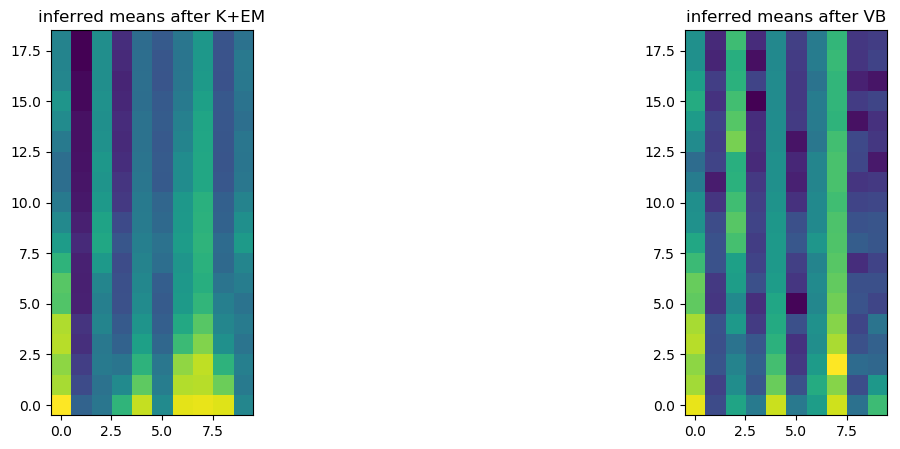

PyObject Text(0.5, 1.0, 'inferred means after VB')

In [20]:
# get new means and variances of remaining clustersand show results
μ_trained = []
V_trained = []
nu_trained = []
α_π_trained = []
for k = 1:nr_clusters
    if k in remaining_clusters
        push!(μ_trained, μ_m_min[k])
        push!(V_trained, V_w_min[k])
        push!(nu_trained, nu_w_min[k])
        push!(α_π_trained, α_π_min[k])
    end
end

# plot new and previous means
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
ax[2].imshow(hcat(μ_trained...), origin="lower")
ax[2].set_title("inferred means after VB")


## Perform speech enhancement

### Step 1: build factor graph

In [21]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars_e = Dict()

# specify distribution over the selection variables
@RV vars_e[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(rm_clusters,)))

# create mixture components
for k = 1:rm_clusters
    
    # specify distribution over precision matrix
    @RV vars_e[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars_e[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars_e[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars_e[:z] ~ Categorical(vars_e[:π])

# create gaussian mixture model
@RV vars_e[:ξ] ~ GaussianMixture(vars_e[:z], expand([[vars_e[pad(:m,ki)], vars_e[pad(:w,ki)]] for ki=1:rm_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars_e[:Xc] ~ ComplexHGF(vars_e[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars_e[:Xr] ~ ComplexToReal(vars_e[:Xc])

# probabilistic Fourier transform
@RV vars_e[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars_e[:Xr]

# observation model 
@RV vars_e[:y] ~ GaussianMeanVariance(vars_e[:x], Σ_noise*Ic(bufsize))

# observation
placeholder(vars_e[:y], :y, dims=(bufsize,))
   
# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7246390266474567267 -->
 7246390266474567267 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 2359605841563225334 -->
 2359605841563225334 
 
 placeholder_μ_m_03 
 
<!-- 7246390266474567267--2359605841563225334 -->
 7246390266474567267--2359605841563225334 
 
 μ_m_03 
 1 out 
 2 m 
 
<!-- 6828601969657143163 -->
 6828601969657143163 
 
 = 
 equ_vars_e_w_05_1 
 
<!-- 10523554996085974837 -->
 10523554996085974837 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 6828601969657143163--10523554996085974837 -->
 6828601969657143163--10523554996085974837 
 
 vars_e_w_05 
 3 w 
 2 2 
 
<!-- 8095878327729843799 -->
 8095878327729843799 
 
 GM 
 gaussianmixture_1 
 
<!-- 6828601969657143163--8095878327729843799 -->
 6828601969657143163--8095878327729843799 
 
 vars_e_w_05 
 12 w5 
 3 3 
 
<!-- 4076792876876550203 -->
 4076792876876550203 
 
 W 
 wishart_5 
 
<!-- 6828601969657143163--4076792876876550203 -->
 6828601969657143163--4076792876876550203 
 
 vars_e_w_05 
 1 out 
 1 1 
 
<!-- 8107332958326959085 -->
 8107332958326959085 
 
 W 
 wishart_9 
 
<!-- 4056144720558853060 -->
 4056144720558853060 
 
 placeholder_V_w_09 
 
<!-- 8107332958326959085--4056144720558853060 -->
 8107332958326959085--4056144720558853060 
 
 V_w_09 
 1 out 
 2 v 
 
<!-- 17072198616438882162 -->
 17072198616438882162 
 
 placeholder_nu_w_09 
 
<!-- 8107332958326959085--17072198616438882162 -->
 8107332958326959085--17072198616438882162 
 
 nu_w_09 
 1 out 
 3 nu 
 
<!-- 1079155070821153900 -->
 1079155070821153900 
 
 𝒩 
 gaussianmeanprecision_6 
 
<!-- 7032847739319201859 -->
 7032847739319201859 
 
 placeholder_μ_m_06 
 
<!-- 1079155070821153900--7032847739319201859 -->
 1079155070821153900--7032847739319201859 
 
 μ_m_06 
 1 out 
 2 m 
 
<!-- 10527860917639666634 -->
 10527860917639666634 
 
 = 
 equ_vars_e_w_06_1 
 
<!-- 10527860917639666634--1079155070821153900 -->
 10527860917639666634--1079155070821153900 
 
 vars_e_w_06 
 3 w 
 2 2 
 
<!-- 10527860917639666634--8095878327729843799 -->
 10527860917639666634--8095878327729843799 
 
 vars_e_w_06 
 14 w6 
 3 3 
 
<!-- 1924604606597457967 -->
 1924604606597457967 
 
 W 
 wishart_6 
 
<!-- 10527860917639666634--1924604606597457967 -->
 10527860917639666634--1924604606597457967 
 
 vars_e_w_06 
 1 out 
 1 1 
 
<!-- 5742355745211490136 -->
 5742355745211490136 
 
 𝒩 
 gaussianmeanprecision_9 
 
<!-- 4149289356373013391 -->
 4149289356373013391 
 
 placeholder_μ_m_09 
 
<!-- 5742355745211490136--4149289356373013391 -->
 5742355745211490136--4149289356373013391 
 
 μ_m_09 
 1 out 
 2 m 
 
<!-- 5641990281372827181 -->
 5641990281372827181 
 
 clamp_1 
 
<!-- 16774171056835486229 -->
 16774171056835486229 
 
 placeholder_V_w_04 
 
<!-- 8889645106875601675 -->
 8889645106875601675 
 
 𝒩 
 gaussianmeanprecision_8 
 
<!-- 10438134558209702286 -->
 10438134558209702286 
 
 placeholder_μ_m_08 
 
<!-- 8889645106875601675--10438134558209702286 -->
 8889645106875601675--10438134558209702286 
 
 μ_m_08 
 1 out 
 2 m 
 
<!-- 16460772223750242257 -->
 16460772223750242257 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 8276746876038580788 -->
 8276746876038580788 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 16460772223750242257--8276746876038580788 -->
 16460772223750242257--8276746876038580788 
 
 vars_e_Xc 
 1 X 
 2 cx 
 
<!-- 1614729935886292445 -->
 1614729935886292445 
 
 𝒩 
 gaussianmeanprecision_7 
 
<!-- 5851787519697946757 -->
 5851787519697946757 
 
 placeholder_μ_m_07 
 
<!-- 1614729935886292445--5851787519697946757 -->
 1614729935886292445--5851787519697946757

### Step 2: Generate inference algorithm

In [22]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:rm_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars_e[:π], 
                           expand([[vars_e[pad(:m,k)], vars_e[pad(:w,k)]] for k=1:rm_clusters])...,
                           vars_e[:z], vars_e[:Xc], vars_e[:ξ], ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: inference

In [23]:
# prevent posdef errors (Marco his comment on ForneyLab issue #86)
function safeChol(A::Hermitian)
    # `safeChol(A)` is a 'safe' version of `chol(A)` in the sense
    # that it adds jitter to the diagonal of `A` and tries again if
    # `chol` raised a `PosDefException`.
    # Matrix `A` can be non-positive-definite in practice even though it
    # shouldn't be in theory due to finite floating point precision.
    # If adding jitter does not help, `PosDefException` will still be raised.
    L = similar(A)
    try
        L = cholesky(A)
        catch #Base.LinAlg.PosDefException
        # Add jitter to diagonal to break linear dependence among rows/columns.
        # The additive noise is input-dependent to make sure that we hit the
        # significant precision of the Float64 values with high probability.
        jitter = Diagonal(1e-13*(rand(size(A,1))) .* diag(A))
        L = cholesky(A + jitter)
    end
end
ForneyLab.unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]
unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]

unsafeMean (generic function with 16 methods)

In [24]:
# create placeholders
ξ_inferred = Array{Float64, 2}(undef, nr_samples_test, nr_freqs)
x_inferred = Array{Float64, 2}(undef, nr_samples_test, bufsize)


p_z_min = exp.(ForneyLab.digamma.(α_π_trained) .- ForneyLab.digamma.(sum(α_π_trained))) ./ sum(exp.(ForneyLab.digamma.(α_π_trained) .- ForneyLab.digamma.(sum(α_π_trained))))

# loop through segments
@showprogress for k = 1:nr_samples_test
    
    # set number of iterations
    nr_its = 10

    # create data dictionary
    data = Dict()

    # specify input data and measurement noise
    data[:y] = y_samples_test_noisy[k] .- mean(y_samples_test_noisy[k])

    # specify priors over class probabilities
    data[:α_π] = α_π_trained

    # specify priors over clusters
    for ki = 1:rm_clusters
        data[pad(:μ_m,ki)] = μ_trained[ki]
        data[pad(:nu_w,ki)] = nu_trained[ki]
        data[pad(:V_w,ki)] =  V_trained[ki]
    end

    # specify probabilistic fourier matrices
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples_test[k]')', sin.(2*pi*fi*t_samples_test[k]')')
    
    # create marginals dictionary
    marginals = Dict()

    # specify marginals over class probabilities
    marginals[:vars_e_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=α_π_trained)

    # specify marginals over clusters
    for ki = 1:rm_clusters
        marginals[pad(:vars_e_m,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,ki)], w=data[pad(:V_w,ki)]*data[pad(:nu_w,ki)])
        marginals[pad(:vars_e_w,ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,ki)], nu=data[pad(:nu_w,ki)])
    end
    
    # specify marginals over samples
    #marginals[:vars_e_z] = vague(Categorical)
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=ps/sum(ps))
    marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=p_z_min)
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=exp.(α_π_trained)/sum(exp.(α_π_trained))) # not sure whether best way
    marginals[:vars_e_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=(1e10)*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_e_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech_n[k,2:end-1], v=1.0*diagm(squeeze(var(z_speech_n[:,2:end-1], dims=1))))
                    
    # perform iterations
    for i = 1:nr_its

        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        
    end
    #try
        ξ_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_ξ])
        x_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_x]) .+ mean(y_samples_test_noisy[k])
    #catch
        #ξ_inferred[k,:] = zeros(nr_freqs)
        #x_inferred[k,:] = zeros(bufsize)
        #println("Posdef Exception, k="*string(k))
    #end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


### Step 4: results

In [25]:
# reshape enhance speech signal
y_enhanced = vcat(x_inferred'...)
;

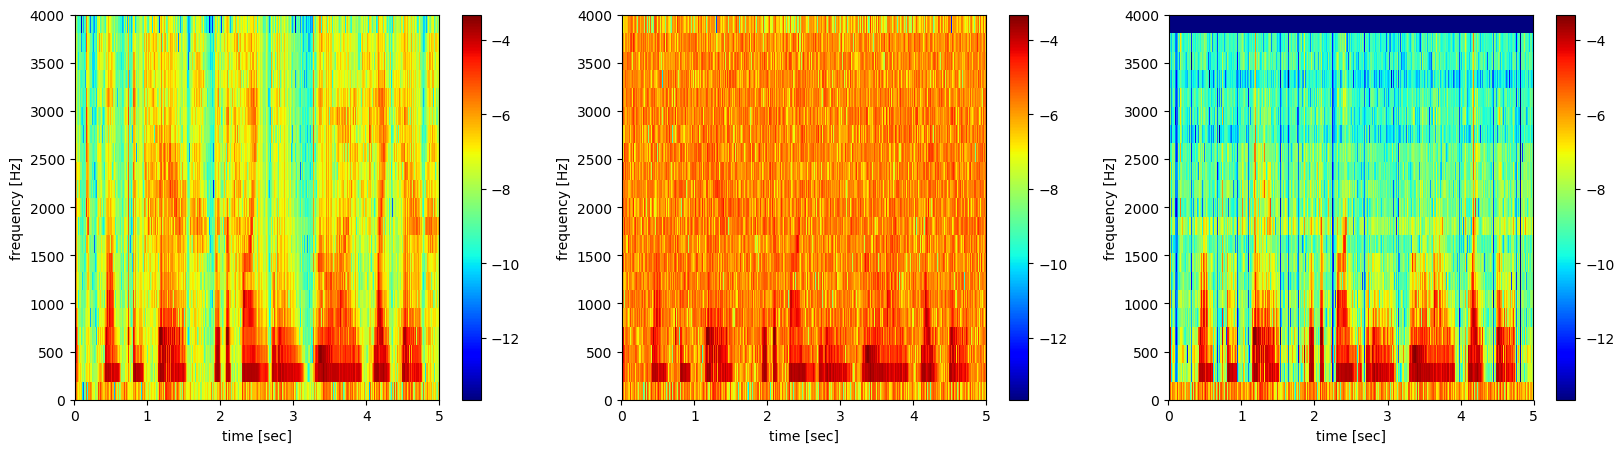

In [26]:
#plt.imshow(ξ_inferred',origin="lower", aspect="auto"), plt.colorbar()
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[2])
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize_test, fs=fs), fs, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

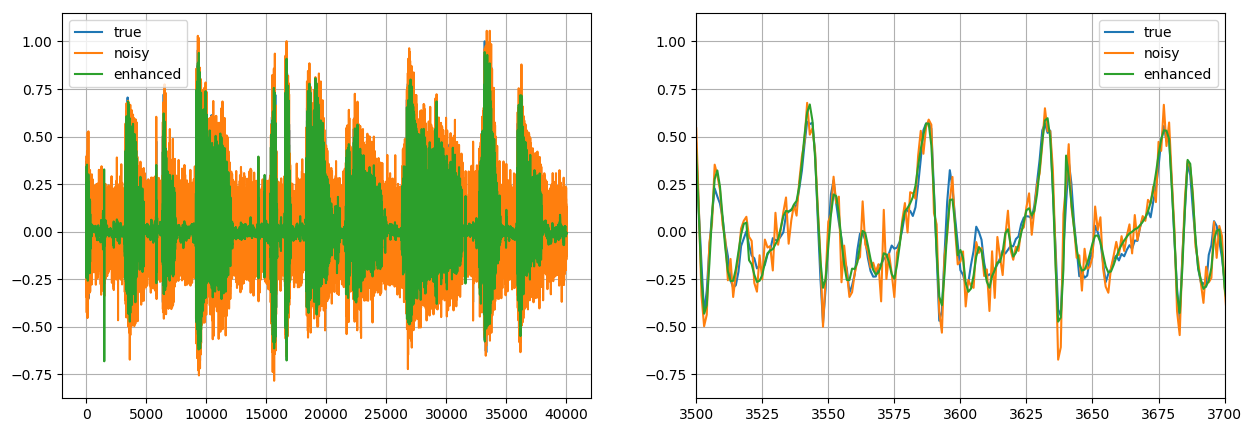

In [27]:
# plot signals
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_enhanced, label="enhanced")
ax[2].plot(y_speech_true, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_enhanced, label="enhanced")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([3500, 3700]), ax[1].legend(), ax[2].legend()
audioplayers(y_speech_true, y_speech_n, y_enhanced, fs=fs)

In [28]:
mean(abs2.(y_speech_true - y_speech_n)), mean(abs2.(y_speech_true - y_enhanced))

(0.009974349673925464, 0.002609559618353416)